In [1]:
import numpy as np
from numba import njit
import pickle
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal

from hyppo.tools import multimodal_independence, indep_sim, rot_ksamp
from hyppo.tools import SIMULATIONS
from hyppo.ksample._utils import k_sample_transform
from tqdm import tqdm
from hyppo.tools import * 

import sys
import os
import multiprocessing as mp
from proglearn import UncertaintyForest
from joblib import Parallel, delayed
sys.path.append('C:\\Users\\siptest\\AppData\\Roaming\\Python\\Python36\\Scripts')
#%load_ext autoreload
#%autoreload 2

In [2]:
class TestStat:
    def __init__(self, uf, oob_func):
        self.uf = uf
        self.oob_func = oob_func

    def __call__(self, X, y):
        if not hasattr(self, "leaf_indices_"):
            self.leaf_indices_ = []
            for tree, voter_indices in zip(self.uf.transformers_, self.uf.voter_indices_):
                self.leaf_indices_.append(tree.transform(X[voter_indices]))
        self._refit_leaves(y)

        _, counts = np.unique(y, return_counts=True)
        H_Y = entropy(counts, base=np.exp(1))
        H_YX = self._apply_oob(X, self.oob_func)
        return H_Y - H_YX

    def _refit_leaves(self, y):
        for leaf_indices, voter, voter_indices in zip(
            self.leaf_indices_, self.uf.voters_, self.uf.voter_indices_
        ):
            voter.fit(leaf_indices, y[voter_indices])

    def _apply_oob(self, X, func):
        sample_uses = np.zeros((len(X),))
        sample_posteriors = None
        for tree, voter, indices in zip(
            self.uf.transformers_, self.uf.voters_, self.uf.voter_indices_
        ):
            pred_posterior = voter.predict_proba(tree.transform(X[indices]))
            if sample_posteriors is None:
                sample_posteriors = np.zeros((len(X), pred_posterior.shape[1]))
            sample_uses[indices] += 1
            sample_posteriors[indices] += pred_posterior

        non_zeros_indices = np.where(sample_uses > 0)[0]
        sample_posteriors = sample_posteriors[non_zeros_indices] / sample_uses[non_zeros_indices, None]

        return np.mean(func(sample_posteriors))


In [3]:
MAX_SAMPLE_SIZE = 300
STEP_SIZE = 50
SAMP_SIZES = range(100, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 100

In [4]:
def _perm_stat(calc_stat, x, y):
    permy = np.random.permutation(y)
    perm_stat = calc_stat(x, permy)

    return perm_stat


def perm_test(calc_stat, X, y, reps=1000, workers=1):
    """
    Calculate the p-value via permutation
    """
    # calculate observed test statistic
    stat = calc_stat(X, y)

    # calculate null distribution
    null_dist = np.array(
        Parallel(n_jobs=workers)(
            [delayed(_perm_stat)(calc_stat, X, y) for rep in range(reps)]
        )
    )
    pvalue = (null_dist >= stat).sum() / reps

    # correct for a p-value of 0. This is because, with bootstrapping
    # permutations, a p-value of 0 is incorrect
    if pvalue == 0:
        pvalue = 1 / reps

    return stat, pvalue

In [5]:
def estimate_power(sim, test):
    
    est_power = []
    for i in tqdm(SAMP_SIZES):
        print("sample size" + str(i))
        print(sim)
        #temp_power = calc_power(test, sim_type="indep", sim=sim, n=i, p=3, auto=False, noise=True)
        pvalues = []
        for _ in tqdm(range(POWER_REPS)): 
            x, y = rot_ksamp(sim, n=i, p=3, noise=True)
            X, y = k_sample_transform([x, y])
            y = y.astype(int)
            y = y.ravel()
            print(X.shape)
            print(y.shape)
            uf = UncertaintyForest(
                n_estimators=100,
                tree_construction_proportion=0.5,
                kappa=np.inf,
                honest_prior="ignore",
                max_features=1.0,
                n_jobs=-2,
            )
            uf = uf.fit(X, y)

            ce = lambda x: entropy(x, axis=1, base=np.exp(1))
            obs_stat = TestStat(uf, ce)

            reps = 100
            stat, pvalue = perm_test(obs_stat, X, y, reps=reps, workers=-2)
            print(pvalue)
            pvalues.append(pvalue)
        #empirical_power = (1 + (pvalues <= 0.05).sum()) / (1 + POWER_REPS) 
        num = 0
        for pval in pvalues: 
            if pval <= 0.05: 
                num += 1
        empirical_power = (1+num) / (1+POWER_REPS)
        est_power.append(empirical_power)
        
    print(est_power)
        
    
    print(sim + " done")
    np.savetxt('C:/Users/siptest/Desktop/NDD/{}_{}HonestSampling_100_estimators_100_reps.csv'.format(sim, "UF"),
            est_power, delimiter=',')
    
    return est_power

In [ ]:
for sim_name in tqdm(SIMULATIONS.keys()): 
    if sim_name != 'linear' and sim_name != 'exponential' and sim_name != 'cubic' and sim_name != 'joint_normal': 
        power = estimate_power(sim_name, "UF")

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

sample size100
step
(200, 4)
(200,)




  1%|▊                                                                               | 1/100 [01:19<2:11:47, 79.87s/it]

0.26
(200, 4)
(200,)




  2%|█▌                                                                              | 2/100 [02:26<2:04:10, 76.03s/it]

0.4
(200, 4)
(200,)




  3%|██▍                                                                             | 3/100 [03:35<1:59:25, 73.87s/it]

0.05
(200, 4)
(200,)




  4%|███▏                                                                            | 4/100 [04:40<1:53:54, 71.19s/it]

0.14
(200, 4)
(200,)




  5%|████                                                                            | 5/100 [05:47<1:50:44, 69.95s/it]

0.46
(200, 4)
(200,)




  6%|████▊                                                                           | 6/100 [06:56<1:49:13, 69.72s/it]

0.59
(200, 4)
(200,)




  7%|█████▌                                                                          | 7/100 [08:05<1:47:22, 69.27s/it]

0.08
(200, 4)
(200,)




  8%|██████▍                                                                         | 8/100 [09:13<1:45:38, 68.90s/it]

0.18
(200, 4)
(200,)




  9%|███████▏                                                                        | 9/100 [10:19<1:43:28, 68.23s/it]

0.17
(200, 4)
(200,)




 10%|███████▉                                                                       | 10/100 [11:26<1:41:28, 67.64s/it]

0.08
(200, 4)
(200,)




 11%|████████▋                                                                      | 11/100 [12:36<1:41:46, 68.61s/it]

0.28
(200, 4)
(200,)




 12%|█████████▍                                                                     | 12/100 [13:54<1:44:41, 71.38s/it]

0.55
(200, 4)
(200,)




 13%|██████████▎                                                                    | 13/100 [15:00<1:41:13, 69.81s/it]

0.1
(200, 4)
(200,)




 14%|███████████                                                                    | 14/100 [16:06<1:38:12, 68.52s/it]

0.03
(200, 4)
(200,)




 15%|███████████▊                                                                   | 15/100 [17:12<1:35:50, 67.65s/it]

0.23
(200, 4)
(200,)




 16%|████████████▋                                                                  | 16/100 [18:16<1:33:27, 66.76s/it]

0.46
(200, 4)
(200,)




 17%|█████████████▍                                                                 | 17/100 [19:25<1:33:12, 67.38s/it]

0.03
(200, 4)
(200,)




 18%|██████████████▏                                                                | 18/100 [20:33<1:32:11, 67.46s/it]

0.07
(200, 4)
(200,)




 19%|███████████████                                                                | 19/100 [21:39<1:30:25, 66.99s/it]

0.24
(200, 4)
(200,)




 20%|███████████████▊                                                               | 20/100 [22:43<1:28:18, 66.24s/it]

0.01
(200, 4)
(200,)




 21%|████████████████▌                                                              | 21/100 [23:49<1:27:02, 66.11s/it]

0.45
(200, 4)
(200,)




 22%|█████████████████▍                                                             | 22/100 [24:54<1:25:24, 65.69s/it]

0.06
(200, 4)
(200,)




 23%|██████████████████▏                                                            | 23/100 [25:58<1:23:51, 65.34s/it]

0.39
(200, 4)
(200,)




 24%|██████████████████▉                                                            | 24/100 [27:00<1:21:25, 64.28s/it]

0.01
(200, 4)
(200,)




 25%|███████████████████▊                                                           | 25/100 [28:04<1:20:22, 64.30s/it]

0.38
(200, 4)
(200,)




 26%|████████████████████▌                                                          | 26/100 [29:12<1:20:36, 65.36s/it]

0.01
(200, 4)
(200,)




 27%|█████████████████████▎                                                         | 27/100 [30:23<1:21:22, 66.88s/it]

0.21
(200, 4)
(200,)




 28%|██████████████████████                                                         | 28/100 [31:22<1:17:42, 64.75s/it]

0.01
(200, 4)
(200,)




 29%|██████████████████████▉                                                        | 29/100 [32:27<1:16:39, 64.79s/it]

0.15
(200, 4)
(200,)




 30%|███████████████████████▋                                                       | 30/100 [33:29<1:14:39, 64.00s/it]

0.01
(200, 4)
(200,)




 31%|████████████████████████▍                                                      | 31/100 [34:34<1:13:49, 64.20s/it]

0.45
(200, 4)
(200,)




 32%|█████████████████████████▎                                                     | 32/100 [35:41<1:13:43, 65.05s/it]

0.33
(200, 4)
(200,)




 33%|██████████████████████████                                                     | 33/100 [36:45<1:12:06, 64.57s/it]

0.17
(200, 4)
(200,)




 34%|██████████████████████████▊                                                    | 34/100 [37:49<1:10:57, 64.51s/it]

0.24
(200, 4)
(200,)




 35%|███████████████████████████▋                                                   | 35/100 [38:53<1:09:47, 64.43s/it]

0.01
(200, 4)
(200,)




 36%|████████████████████████████▍                                                  | 36/100 [40:03<1:10:21, 65.96s/it]

0.19
(200, 4)
(200,)




 37%|█████████████████████████████▏                                                 | 37/100 [41:07<1:08:46, 65.51s/it]

0.02
(200, 4)
(200,)




 38%|██████████████████████████████                                                 | 38/100 [42:15<1:08:27, 66.26s/it]

0.23
(200, 4)
(200,)




 39%|██████████████████████████████▊                                                | 39/100 [43:27<1:08:55, 67.80s/it]

0.57
(200, 4)
(200,)




 40%|███████████████████████████████▌                                               | 40/100 [44:33<1:07:16, 67.28s/it]

0.23
(200, 4)
(200,)




 41%|████████████████████████████████▍                                              | 41/100 [45:35<1:04:46, 65.87s/it]

0.01
(200, 4)
(200,)




 42%|█████████████████████████████████▏                                             | 42/100 [46:40<1:03:26, 65.63s/it]

0.16
(200, 4)
(200,)




 43%|█████████████████████████████████▉                                             | 43/100 [47:46<1:02:22, 65.65s/it]

0.01
(200, 4)
(200,)




 44%|██████████████████████████████████▊                                            | 44/100 [48:56<1:02:36, 67.07s/it]

0.41
(200, 4)
(200,)




 45%|███████████████████████████████████▌                                           | 45/100 [50:02<1:01:04, 66.62s/it]

0.45
(200, 4)
(200,)




 46%|█████████████████████████████████████▎                                           | 46/100 [50:59<57:21, 63.73s/it]

0.58
(200, 4)
(200,)




 47%|██████████████████████████████████████                                           | 47/100 [51:24<46:09, 52.26s/it]

0.01
(200, 4)
(200,)




 48%|██████████████████████████████████████▉                                          | 48/100 [51:51<38:41, 44.65s/it]

0.02
(200, 4)
(200,)




 49%|███████████████████████████████████████▋                                         | 49/100 [52:19<33:29, 39.41s/it]

0.07
(200, 4)
(200,)




 50%|████████████████████████████████████████▌                                        | 50/100 [52:45<29:41, 35.64s/it]

0.02
(200, 4)
(200,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [53:21<29:03, 35.57s/it]

0.01
(200, 4)
(200,)




 52%|██████████████████████████████████████████                                       | 52/100 [54:01<29:41, 37.10s/it]

0.01
(200, 4)
(200,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [54:42<29:54, 38.19s/it]

0.05
(200, 4)
(200,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [55:26<30:39, 39.98s/it]

0.24
(200, 4)
(200,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [56:23<33:47, 45.06s/it]

0.02
(200, 4)
(200,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [57:21<35:52, 48.91s/it]

0.39
(200, 4)
(200,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [58:37<40:49, 56.96s/it]

0.01
(200, 4)
(200,)




 58%|█████████████████████████████████████████████▊                                 | 58/100 [1:00:01<45:28, 64.96s/it]

0.01
(200, 4)
(200,)




 59%|██████████████████████████████████████████████▌                                | 59/100 [1:00:51<41:26, 60.64s/it]

0.11
(200, 4)
(200,)




 60%|███████████████████████████████████████████████▍                               | 60/100 [1:01:51<40:12, 60.31s/it]

0.05
(200, 4)
(200,)




 61%|████████████████████████████████████████████████▏                              | 61/100 [1:02:41<37:17, 57.37s/it]

0.01
(200, 4)
(200,)




 62%|████████████████████████████████████████████████▉                              | 62/100 [1:03:34<35:33, 56.14s/it]

0.12
(200, 4)
(200,)




 63%|█████████████████████████████████████████████████▊                             | 63/100 [1:04:29<34:20, 55.68s/it]

0.39
(200, 4)
(200,)




 64%|██████████████████████████████████████████████████▌                            | 64/100 [1:05:21<32:46, 54.62s/it]

0.39
(200, 4)
(200,)




 65%|███████████████████████████████████████████████████▎                           | 65/100 [1:06:13<31:25, 53.88s/it]

0.39
(200, 4)
(200,)




 66%|████████████████████████████████████████████████████▏                          | 66/100 [1:07:05<30:05, 53.09s/it]

0.01
(200, 4)
(200,)




 67%|████████████████████████████████████████████████████▉                          | 67/100 [1:07:58<29:16, 53.22s/it]

0.59
(200, 4)
(200,)




 68%|█████████████████████████████████████████████████████▋                         | 68/100 [1:09:02<30:02, 56.32s/it]

0.09
(200, 4)
(200,)




 69%|██████████████████████████████████████████████████████▌                        | 69/100 [1:09:49<27:42, 53.64s/it]

0.19
(200, 4)
(200,)




 70%|███████████████████████████████████████████████████████▎                       | 70/100 [1:10:37<25:53, 51.79s/it]

0.37
(200, 4)
(200,)




 71%|████████████████████████████████████████████████████████                       | 71/100 [1:11:24<24:20, 50.37s/it]

0.45
(200, 4)
(200,)




 72%|████████████████████████████████████████████████████████▉                      | 72/100 [1:12:18<24:08, 51.73s/it]

0.67
(200, 4)
(200,)




 73%|█████████████████████████████████████████████████████████▋                     | 73/100 [1:13:03<22:14, 49.43s/it]

0.02
(200, 4)
(200,)




 74%|██████████████████████████████████████████████████████████▍                    | 74/100 [1:13:54<21:42, 50.11s/it]

0.16
(200, 4)
(200,)




 75%|███████████████████████████████████████████████████████████▎                   | 75/100 [1:14:46<21:08, 50.74s/it]

0.16
(200, 4)
(200,)




 76%|████████████████████████████████████████████████████████████                   | 76/100 [1:15:28<19:14, 48.11s/it]

0.23
(200, 4)
(200,)




 77%|████████████████████████████████████████████████████████████▊                  | 77/100 [1:16:17<18:28, 48.21s/it]

0.06
(200, 4)
(200,)




 78%|█████████████████████████████████████████████████████████████▌                 | 78/100 [1:16:50<16:02, 43.75s/it]

0.07
(200, 4)
(200,)




 79%|██████████████████████████████████████████████████████████████▍                | 79/100 [1:17:17<13:29, 38.57s/it]

0.04
(200, 4)
(200,)




 80%|███████████████████████████████████████████████████████████████▏               | 80/100 [1:17:43<11:37, 34.89s/it]

0.02
(200, 4)
(200,)




 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:18:10<10:18, 32.58s/it]

0.55
(200, 4)
(200,)




 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:18:40<09:31, 31.75s/it]

0.16
(200, 4)
(200,)




 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:19:06<08:31, 30.10s/it]

0.01
(200, 4)
(200,)




 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:19:32<07:42, 28.94s/it]

0.01
(200, 4)
(200,)




 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:19:59<07:04, 28.30s/it]

0.6
(200, 4)
(200,)




 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:20:28<06:37, 28.37s/it]

0.35
(200, 4)
(200,)




 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:20:56<06:09, 28.43s/it]

0.09
(200, 4)
(200,)




 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:21:23<05:34, 27.88s/it]

0.06
(200, 4)
(200,)




 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:21:49<05:00, 27.34s/it]

0.01
(200, 4)
(200,)




 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:22:15<04:30, 27.03s/it]

0.13
(200, 4)
(200,)




 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:22:43<04:04, 27.16s/it]

0.33
(200, 4)
(200,)




 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:23:09<03:33, 26.74s/it]

0.01
(200, 4)
(200,)




 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:23:35<03:07, 26.72s/it]

0.15
(200, 4)
(200,)




 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:24:01<02:39, 26.54s/it]

0.01
(200, 4)
(200,)




 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:24:27<02:11, 26.29s/it]

0.04
(200, 4)
(200,)




 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:24:54<01:45, 26.42s/it]

0.71
(200, 4)
(200,)




 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:25:19<01:18, 26.20s/it]

0.02
(200, 4)
(200,)




 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:25:46<00:52, 26.33s/it]

0.33
(200, 4)
(200,)




 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:26:12<00:26, 26.05s/it]

0.04
(200, 4)
(200,)




100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:26:38<00:00, 51.99s/it]

 20%|███████████████▌                                                              | 1/5 [1:26:38<5:46:34, 5198.56s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.05
sample size150
step
(300, 4)
(300,)




  1%|▊                                                                                 | 1/100 [00:35<57:45, 35.01s/it]

0.04
(300, 4)
(300,)




  2%|█▋                                                                                | 2/100 [01:08<56:36, 34.65s/it]

0.02
(300, 4)
(300,)




  3%|██▍                                                                               | 3/100 [01:45<56:48, 35.14s/it]

0.05
(300, 4)
(300,)




  4%|███▎                                                                              | 4/100 [02:22<57:24, 35.88s/it]

0.01
(300, 4)
(300,)




  5%|████                                                                              | 5/100 [02:55<55:28, 35.04s/it]

0.08
(300, 4)
(300,)




  6%|████▉                                                                             | 6/100 [03:29<54:28, 34.77s/it]

0.46
(300, 4)
(300,)




  7%|█████▋                                                                            | 7/100 [04:07<55:03, 35.52s/it]

0.05
(300, 4)
(300,)




  8%|██████▌                                                                           | 8/100 [04:41<53:54, 35.16s/it]

0.01
(300, 4)
(300,)




  9%|███████▍                                                                          | 9/100 [05:16<53:11, 35.08s/it]

0.03
(300, 4)
(300,)




 10%|████████                                                                         | 10/100 [05:51<52:35, 35.06s/it]

0.46
(300, 4)
(300,)




 11%|████████▉                                                                        | 11/100 [06:25<51:31, 34.74s/it]

0.11
(300, 4)
(300,)




 12%|█████████▋                                                                       | 12/100 [06:59<50:33, 34.47s/it]

0.01
(300, 4)
(300,)




 13%|██████████▌                                                                      | 13/100 [07:32<49:30, 34.14s/it]

0.07
(300, 4)
(300,)




 14%|███████████▎                                                                     | 14/100 [08:06<48:44, 34.01s/it]

0.02
(300, 4)
(300,)




 15%|████████████▏                                                                    | 15/100 [08:40<48:09, 34.00s/it]

0.21
(300, 4)
(300,)




 16%|████████████▉                                                                    | 16/100 [09:14<47:52, 34.20s/it]

0.07
(300, 4)
(300,)




 17%|█████████████▊                                                                   | 17/100 [09:49<47:19, 34.22s/it]

0.07
(300, 4)
(300,)




 18%|██████████████▌                                                                  | 18/100 [10:22<46:33, 34.07s/it]

0.12
(300, 4)
(300,)




 19%|███████████████▍                                                                 | 19/100 [10:57<46:11, 34.22s/it]

0.01
(300, 4)
(300,)




 20%|████████████████▏                                                                | 20/100 [11:30<45:17, 33.97s/it]

0.01
(300, 4)
(300,)




 21%|█████████████████                                                                | 21/100 [12:09<46:22, 35.23s/it]

0.01
(300, 4)
(300,)




 22%|█████████████████▊                                                               | 22/100 [12:42<45:07, 34.71s/it]

0.01
(300, 4)
(300,)




 23%|██████████████████▋                                                              | 23/100 [13:16<44:07, 34.39s/it]

0.01
(300, 4)
(300,)




 24%|███████████████████▍                                                             | 24/100 [13:48<42:48, 33.80s/it]

0.01
(300, 4)
(300,)




 25%|████████████████████▎                                                            | 25/100 [14:23<42:31, 34.02s/it]

0.84
(300, 4)
(300,)




 26%|█████████████████████                                                            | 26/100 [14:57<42:14, 34.25s/it]

0.02
(300, 4)
(300,)




 27%|█████████████████████▊                                                           | 27/100 [15:31<41:30, 34.12s/it]

0.02
(300, 4)
(300,)




 28%|██████████████████████▋                                                          | 28/100 [16:05<40:38, 33.87s/it]

0.03
(300, 4)
(300,)




 29%|███████████████████████▍                                                         | 29/100 [16:39<40:13, 33.99s/it]

0.14
(300, 4)
(300,)




 30%|████████████████████████▎                                                        | 30/100 [17:13<39:39, 34.00s/it]

0.05
(300, 4)
(300,)




 31%|█████████████████████████                                                        | 31/100 [17:47<39:02, 33.94s/it]

0.24
(300, 4)
(300,)




 32%|█████████████████████████▉                                                       | 32/100 [18:21<38:32, 34.00s/it]

0.13
(300, 4)
(300,)




 33%|██████████████████████████▋                                                      | 33/100 [18:54<37:39, 33.72s/it]

0.01
(300, 4)
(300,)




 34%|███████████████████████████▌                                                     | 34/100 [19:28<37:04, 33.71s/it]

0.06
(300, 4)
(300,)




 35%|████████████████████████████▎                                                    | 35/100 [20:50<52:30, 48.47s/it]

0.01
(300, 4)
(300,)




 36%|████████████████████████████▍                                                  | 36/100 [22:19<1:04:32, 60.51s/it]

0.01
(300, 4)
(300,)




 37%|█████████████████████████████▉                                                   | 37/100 [22:52<54:57, 52.34s/it]

0.01
(300, 4)
(300,)




 38%|██████████████████████████████▊                                                  | 38/100 [23:27<48:37, 47.05s/it]

0.33
(300, 4)
(300,)




 39%|███████████████████████████████▌                                                 | 39/100 [24:03<44:17, 43.56s/it]

0.07
(300, 4)
(300,)




 40%|████████████████████████████████▍                                                | 40/100 [24:37<40:52, 40.87s/it]

0.5
(300, 4)
(300,)




 41%|█████████████████████████████████▏                                               | 41/100 [25:12<38:22, 39.03s/it]

0.01
(300, 4)
(300,)




 42%|██████████████████████████████████                                               | 42/100 [25:46<36:12, 37.46s/it]

0.03
(300, 4)
(300,)




 43%|██████████████████████████████████▊                                              | 43/100 [26:20<34:37, 36.46s/it]

0.01
(300, 4)
(300,)




 44%|███████████████████████████████████▋                                             | 44/100 [26:54<33:21, 35.74s/it]

0.01
(300, 4)
(300,)




 45%|████████████████████████████████████▍                                            | 45/100 [27:28<32:15, 35.18s/it]

0.01
(300, 4)
(300,)




 46%|█████████████████████████████████████▎                                           | 46/100 [28:02<31:28, 34.97s/it]

0.41
(300, 4)
(300,)




 47%|██████████████████████████████████████                                           | 47/100 [28:37<30:47, 34.85s/it]

0.22
(300, 4)
(300,)




 48%|██████████████████████████████████████▉                                          | 48/100 [29:10<29:45, 34.34s/it]

0.01
(300, 4)
(300,)




 49%|███████████████████████████████████████▋                                         | 49/100 [29:44<29:08, 34.29s/it]

0.03
(300, 4)
(300,)




 50%|████████████████████████████████████████▌                                        | 50/100 [30:23<29:40, 35.61s/it]

0.16
(300, 4)
(300,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [30:57<28:48, 35.27s/it]

0.02
(300, 4)
(300,)




 52%|██████████████████████████████████████████                                       | 52/100 [31:32<28:09, 35.20s/it]

0.03
(300, 4)
(300,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [32:14<29:08, 37.21s/it]

0.38
(300, 4)
(300,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [32:49<27:52, 36.36s/it]

0.01
(300, 4)
(300,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [33:23<26:46, 35.70s/it]

0.01
(300, 4)
(300,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [33:58<26:11, 35.71s/it]

0.07
(300, 4)
(300,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [34:43<27:35, 38.50s/it]

0.01
(300, 4)
(300,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [35:17<25:57, 37.07s/it]

0.01
(300, 4)
(300,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [35:52<24:47, 36.29s/it]

0.11
(300, 4)
(300,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [36:27<24:05, 36.13s/it]

0.64
(300, 4)
(300,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [37:02<23:13, 35.72s/it]

0.2
(300, 4)
(300,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [37:36<22:17, 35.20s/it]

0.01
(300, 4)
(300,)




 63%|███████████████████████████████████████████████████                              | 63/100 [38:11<21:37, 35.08s/it]

0.02
(300, 4)
(300,)




 64%|███████████████████████████████████████████████████▊                             | 64/100 [38:45<20:56, 34.91s/it]

0.06
(300, 4)
(300,)




 65%|████████████████████████████████████████████████████▋                            | 65/100 [39:20<20:15, 34.74s/it]

0.02
(300, 4)
(300,)




 66%|█████████████████████████████████████████████████████▍                           | 66/100 [39:54<19:35, 34.58s/it]

0.02
(300, 4)
(300,)




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [40:27<18:48, 34.20s/it]

0.01
(300, 4)
(300,)




 68%|███████████████████████████████████████████████████████                          | 68/100 [41:02<18:17, 34.29s/it]

0.03
(300, 4)
(300,)




 69%|███████████████████████████████████████████████████████▉                         | 69/100 [41:37<17:51, 34.57s/it]

0.01
(300, 4)
(300,)




 70%|████████████████████████████████████████████████████████▋                        | 70/100 [42:15<17:47, 35.60s/it]

0.01
(300, 4)
(300,)




 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [42:50<17:04, 35.34s/it]

0.1
(300, 4)
(300,)




 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [43:23<16:11, 34.69s/it]

0.02
(300, 4)
(300,)




 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [43:59<15:48, 35.14s/it]

0.54
(300, 4)
(300,)




 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [44:34<15:09, 34.98s/it]

0.01
(300, 4)
(300,)




 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [45:07<14:22, 34.50s/it]

0.02
(300, 4)
(300,)




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [45:42<13:50, 34.61s/it]

0.04
(300, 4)
(300,)




 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [46:16<13:08, 34.28s/it]

0.01
(300, 4)
(300,)




 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [46:49<12:29, 34.08s/it]

0.03
(300, 4)
(300,)




 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [47:24<11:57, 34.17s/it]

0.04
(300, 4)
(300,)




 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [47:57<11:20, 34.03s/it]

0.01
(300, 4)
(300,)




 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [48:32<10:49, 34.21s/it]

0.08
(300, 4)
(300,)




 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [49:07<10:20, 34.46s/it]

0.27
(300, 4)
(300,)




 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [49:40<09:39, 34.10s/it]

0.07
(300, 4)
(300,)


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


 84%|███████████████████████████████████████████████████████████████            | 84/100 [2:52:29<9:55:52, 2234.56s/it]

0.07
(300, 4)
(300,)




 85%|███████████████████████████████████████████████████████████████▊           | 85/100 [2:53:41<6:36:25, 1585.72s/it]

0.01
(300, 4)
(300,)




 86%|████████████████████████████████████████████████████████████████▌          | 86/100 [2:54:20<4:21:43, 1121.69s/it]

0.01
(300, 4)
(300,)




 87%|██████████████████████████████████████████████████████████████████          | 87/100 [2:54:55<2:52:22, 795.61s/it]

0.01
(300, 4)
(300,)




 88%|██████████████████████████████████████████████████████████████████▉         | 88/100 [2:55:29<1:53:26, 567.18s/it]

0.18
(300, 4)
(300,)




 89%|███████████████████████████████████████████████████████████████████▋        | 89/100 [2:56:03<1:14:38, 407.15s/it]

0.01
(300, 4)
(300,)




 90%|██████████████████████████████████████████████████████████████████████▏       | 90/100 [2:56:37<49:14, 295.48s/it]

0.12
(300, 4)
(300,)




 91%|██████████████████████████████████████████████████████████████████████▉       | 91/100 [2:57:25<33:09, 221.04s/it]

0.01
(300, 4)
(300,)




 92%|███████████████████████████████████████████████████████████████████████▊      | 92/100 [2:58:12<22:30, 168.86s/it]

0.8
(300, 4)
(300,)




 93%|████████████████████████████████████████████████████████████████████████▌     | 93/100 [2:58:45<14:55, 127.99s/it]

0.01
(300, 4)
(300,)




 94%|█████████████████████████████████████████████████████████████████████████▎    | 94/100 [2:59:20<10:01, 100.28s/it]

0.04
(300, 4)
(300,)




 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [2:59:56<06:44, 80.97s/it]

0.01
(300, 4)
(300,)




 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [3:00:30<04:27, 66.94s/it]

0.06
(300, 4)
(300,)




 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [3:01:06<02:52, 57.43s/it]

0.02
(300, 4)
(300,)




 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [3:01:40<01:40, 50.45s/it]

0.01
(300, 4)
(300,)




 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [3:02:22<00:47, 47.93s/it]

0.07
(300, 4)
(300,)




100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [3:02:56<00:00, 109.77s/it]

 40%|███████████████████████████████▏                                              | 2/5 [4:29:35<5:46:36, 6932.04s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.02
sample size200
step
(400, 4)
(400,)




  1%|▊                                                                               | 1/100 [00:42<1:10:42, 42.85s/it]

0.01
(400, 4)
(400,)




  2%|█▌                                                                              | 2/100 [01:25<1:10:05, 42.91s/it]

0.03
(400, 4)
(400,)




  3%|██▍                                                                             | 3/100 [02:06<1:08:19, 42.26s/it]

0.01
(400, 4)
(400,)




  4%|███▏                                                                            | 4/100 [02:50<1:08:14, 42.65s/it]

0.01
(400, 4)
(400,)




  5%|████                                                                            | 5/100 [03:30<1:06:30, 42.01s/it]

0.01
(400, 4)
(400,)




  6%|████▊                                                                           | 6/100 [04:12<1:05:47, 42.00s/it]

0.3
(400, 4)
(400,)




  7%|█████▌                                                                          | 7/100 [04:53<1:04:34, 41.66s/it]

0.01
(400, 4)
(400,)




  8%|██████▍                                                                         | 8/100 [05:34<1:03:36, 41.48s/it]

0.02
(400, 4)
(400,)




  9%|███████▏                                                                        | 9/100 [06:16<1:03:03, 41.58s/it]

0.01
(400, 4)
(400,)




 10%|███████▉                                                                       | 10/100 [07:01<1:03:45, 42.50s/it]

0.28
(400, 4)
(400,)




 11%|████████▋                                                                      | 11/100 [07:43<1:03:10, 42.59s/it]

0.01
(400, 4)
(400,)




 12%|█████████▍                                                                     | 12/100 [08:24<1:01:39, 42.04s/it]

0.01
(400, 4)
(400,)




 13%|██████████▎                                                                    | 13/100 [09:10<1:02:47, 43.31s/it]

0.03
(400, 4)
(400,)




 14%|███████████                                                                    | 14/100 [09:52<1:01:20, 42.79s/it]

0.01
(400, 4)
(400,)




 15%|████████████▏                                                                    | 15/100 [10:33<59:52, 42.27s/it]

0.01
(400, 4)
(400,)




 16%|████████████▉                                                                    | 16/100 [11:14<58:35, 41.85s/it]

0.01
(400, 4)
(400,)




 17%|█████████████▊                                                                   | 17/100 [11:55<57:37, 41.66s/it]

0.32
(400, 4)
(400,)




 18%|██████████████▌                                                                  | 18/100 [12:35<56:14, 41.15s/it]

0.01
(400, 4)
(400,)




 19%|███████████████▍                                                                 | 19/100 [13:17<55:44, 41.29s/it]

0.01
(400, 4)
(400,)




 20%|████████████████▏                                                                | 20/100 [13:59<55:21, 41.52s/it]

0.01
(400, 4)
(400,)




 21%|█████████████████                                                                | 21/100 [14:41<54:49, 41.64s/it]

0.01
(400, 4)
(400,)




 22%|█████████████████▊                                                               | 22/100 [15:22<54:06, 41.62s/it]

0.04
(400, 4)
(400,)




 23%|██████████████████▋                                                              | 23/100 [16:03<53:08, 41.41s/it]

0.01
(400, 4)
(400,)




 24%|███████████████████▍                                                             | 24/100 [16:43<51:50, 40.93s/it]

0.01
(400, 4)
(400,)




 25%|████████████████████▎                                                            | 25/100 [17:23<50:43, 40.57s/it]

0.01
(400, 4)
(400,)




 26%|█████████████████████                                                            | 26/100 [18:04<50:14, 40.74s/it]

0.01
(400, 4)
(400,)




 27%|█████████████████████▊                                                           | 27/100 [18:46<50:05, 41.17s/it]

0.01
(400, 4)
(400,)




 28%|██████████████████████▋                                                          | 28/100 [19:30<50:14, 41.87s/it]

0.01
(400, 4)
(400,)




 29%|███████████████████████▍                                                         | 29/100 [20:11<49:28, 41.80s/it]

0.01
(400, 4)
(400,)




 30%|████████████████████████▎                                                        | 30/100 [20:54<49:09, 42.14s/it]

0.04
(400, 4)
(400,)




 31%|█████████████████████████                                                        | 31/100 [21:35<48:04, 41.81s/it]

0.01
(400, 4)
(400,)




 32%|█████████████████████████▉                                                       | 32/100 [22:16<47:11, 41.64s/it]

0.01
(400, 4)
(400,)




 33%|██████████████████████████▋                                                      | 33/100 [22:58<46:23, 41.54s/it]

0.01
(400, 4)
(400,)




 34%|███████████████████████████▌                                                     | 34/100 [23:40<45:56, 41.77s/it]

0.09
(400, 4)
(400,)




 35%|███████████████████████████▋                                                   | 35/100 [25:12<1:01:25, 56.70s/it]

0.03
(400, 4)
(400,)




 36%|████████████████████████████▍                                                  | 36/100 [26:45<1:12:11, 67.68s/it]

0.01
(400, 4)
(400,)




 37%|█████████████████████████████▏                                                 | 37/100 [28:18<1:19:02, 75.27s/it]

0.01
(400, 4)
(400,)




 38%|██████████████████████████████                                                 | 38/100 [29:54<1:24:20, 81.62s/it]

0.01
(400, 4)
(400,)




 39%|██████████████████████████████▊                                                | 39/100 [31:30<1:27:11, 85.77s/it]

0.03
(400, 4)
(400,)




 40%|███████████████████████████████▌                                               | 40/100 [33:01<1:27:24, 87.41s/it]

0.01
(400, 4)
(400,)




 41%|████████████████████████████████▍                                              | 41/100 [34:38<1:28:44, 90.25s/it]

0.01
(400, 4)
(400,)




 42%|█████████████████████████████████▏                                             | 42/100 [36:12<1:28:18, 91.35s/it]

0.01
(400, 4)
(400,)




 43%|█████████████████████████████████▉                                             | 43/100 [37:42<1:26:30, 91.06s/it]

0.01
(400, 4)
(400,)




 44%|██████████████████████████████████▊                                            | 44/100 [39:23<1:27:50, 94.12s/it]

0.02
(400, 4)
(400,)




 45%|███████████████████████████████████▌                                           | 45/100 [41:03<1:27:49, 95.82s/it]

0.08
(400, 4)
(400,)




 46%|████████████████████████████████████▎                                          | 46/100 [42:40<1:26:27, 96.06s/it]

0.01
(400, 4)
(400,)




 47%|█████████████████████████████████████▏                                         | 47/100 [44:15<1:24:44, 95.94s/it]

0.25
(400, 4)
(400,)




 48%|█████████████████████████████████████▉                                         | 48/100 [45:48<1:22:18, 94.97s/it]

0.01
(400, 4)
(400,)




 49%|██████████████████████████████████████▋                                        | 49/100 [47:23<1:20:48, 95.06s/it]

0.01
(400, 4)
(400,)




 50%|███████████████████████████████████████▌                                       | 50/100 [49:02<1:19:59, 95.98s/it]

0.02
(400, 4)
(400,)




 51%|████████████████████████████████████████▎                                      | 51/100 [50:21<1:14:17, 90.97s/it]

0.15
(400, 4)
(400,)




 52%|█████████████████████████████████████████                                      | 52/100 [51:12<1:03:20, 79.18s/it]

0.01
(400, 4)
(400,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [52:02<54:58, 70.18s/it]

0.01
(400, 4)
(400,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [52:53<49:32, 64.61s/it]

0.01
(400, 4)
(400,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [53:44<45:15, 60.33s/it]

0.01
(400, 4)
(400,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [54:35<42:20, 57.74s/it]

0.01
(400, 4)
(400,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [55:28<40:23, 56.35s/it]

0.01
(400, 4)
(400,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [56:17<37:48, 54.00s/it]

0.04
(400, 4)
(400,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [57:04<35:32, 52.01s/it]

0.01
(400, 4)
(400,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [57:52<33:53, 50.83s/it]

0.01
(400, 4)
(400,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [58:53<34:51, 53.62s/it]

0.01
(400, 4)
(400,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [59:51<34:55, 55.15s/it]

0.01
(400, 4)
(400,)




 63%|█████████████████████████████████████████████████▊                             | 63/100 [1:00:43<33:25, 54.20s/it]

0.01
(400, 4)
(400,)




 64%|██████████████████████████████████████████████████▌                            | 64/100 [1:01:33<31:42, 52.85s/it]

0.01
(400, 4)
(400,)




 65%|███████████████████████████████████████████████████▎                           | 65/100 [1:02:27<30:57, 53.06s/it]

0.08
(400, 4)
(400,)




 66%|████████████████████████████████████████████████████▏                          | 66/100 [1:03:13<29:02, 51.24s/it]

0.01
(400, 4)
(400,)




 67%|████████████████████████████████████████████████████▉                          | 67/100 [1:04:09<28:55, 52.59s/it]

0.01
(400, 4)
(400,)




 68%|█████████████████████████████████████████████████████▋                         | 68/100 [1:04:57<27:13, 51.05s/it]

0.08
(400, 4)
(400,)




 69%|██████████████████████████████████████████████████████▌                        | 69/100 [1:05:45<26:01, 50.37s/it]

0.02
(400, 4)
(400,)




 70%|███████████████████████████████████████████████████████▎                       | 70/100 [1:06:33<24:47, 49.58s/it]

0.02
(400, 4)
(400,)




 71%|████████████████████████████████████████████████████████                       | 71/100 [1:07:26<24:22, 50.43s/it]

0.01
(400, 4)
(400,)




 72%|████████████████████████████████████████████████████████▉                      | 72/100 [1:08:16<23:33, 50.49s/it]

0.01
(400, 4)
(400,)




 73%|█████████████████████████████████████████████████████████▋                     | 73/100 [1:09:07<22:48, 50.68s/it]

0.01
(400, 4)
(400,)




 74%|██████████████████████████████████████████████████████████▍                    | 74/100 [1:09:56<21:42, 50.10s/it]

0.01
(400, 4)
(400,)




 75%|███████████████████████████████████████████████████████████▎                   | 75/100 [1:10:58<22:20, 53.62s/it]

0.01
(400, 4)
(400,)




 76%|████████████████████████████████████████████████████████████                   | 76/100 [1:11:46<20:44, 51.87s/it]

0.01
(400, 4)
(400,)




 77%|████████████████████████████████████████████████████████████▊                  | 77/100 [1:12:33<19:22, 50.54s/it]

0.01
(400, 4)
(400,)




 78%|█████████████████████████████████████████████████████████████▌                 | 78/100 [1:13:28<19:02, 51.95s/it]

0.5
(400, 4)
(400,)




 79%|██████████████████████████████████████████████████████████████▍                | 79/100 [1:14:28<18:57, 54.15s/it]

0.65
(400, 4)
(400,)




 80%|███████████████████████████████████████████████████████████████▏               | 80/100 [1:15:16<17:30, 52.53s/it]

0.01
(400, 4)
(400,)




 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:16:20<17:40, 55.83s/it]

0.04
(400, 4)
(400,)




 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:17:16<16:45, 55.88s/it]

0.01
(400, 4)
(400,)




 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:18:23<16:45, 59.15s/it]

0.03
(400, 4)
(400,)




 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:19:14<15:07, 56.70s/it]

0.01
(400, 4)
(400,)




 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:20:01<13:28, 53.87s/it]

0.01
(400, 4)
(400,)




 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:20:48<12:05, 51.84s/it]

0.01
(400, 4)
(400,)




 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:21:34<10:51, 50.09s/it]

0.01
(400, 4)
(400,)




 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:22:20<09:44, 48.69s/it]

0.01
(400, 4)
(400,)




 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:23:07<08:50, 48.19s/it]

0.01
(400, 4)
(400,)




 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:24:02<08:23, 50.30s/it]

0.01
(400, 4)
(400,)




 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:25:08<08:16, 55.20s/it]

0.01
(400, 4)
(400,)




 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:26:15<07:48, 58.61s/it]

0.01
(400, 4)
(400,)




 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:27:21<07:06, 60.96s/it]

0.01
(400, 4)
(400,)




 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:28:25<06:10, 61.70s/it]

0.01
(400, 4)
(400,)




 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:30:00<05:58, 71.61s/it]

0.04
(400, 4)
(400,)




 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:31:01<04:34, 68.60s/it]

0.01
(400, 4)
(400,)




 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:32:08<03:24, 68.06s/it]

0.01
(400, 4)
(400,)




 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:33:02<02:07, 63.76s/it]

0.02
(400, 4)
(400,)




 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:34:12<01:05, 65.84s/it]

0.01
(400, 4)
(400,)




100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:35:15<00:00, 57.16s/it]

 60%|██████████████████████████████████████████████▊                               | 3/5 [6:04:51<3:38:54, 6567.21s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.49
sample size250
step
(500, 4)
(500,)




  1%|▊                                                                               | 1/100 [01:09<1:54:22, 69.32s/it]

0.01
(500, 4)
(500,)




  2%|█▌                                                                              | 2/100 [02:14<1:51:02, 67.98s/it]

0.01
(500, 4)
(500,)




  3%|██▍                                                                             | 3/100 [03:20<1:49:02, 67.45s/it]

0.03
(500, 4)
(500,)




  4%|███▏                                                                            | 4/100 [04:24<1:46:05, 66.31s/it]

0.14
(500, 4)
(500,)




  5%|████                                                                            | 5/100 [05:32<1:46:06, 67.02s/it]

0.03
(500, 4)
(500,)




  6%|████▊                                                                           | 6/100 [06:31<1:40:55, 64.42s/it]

0.01
(500, 4)
(500,)




  7%|█████▌                                                                          | 7/100 [07:26<1:35:45, 61.78s/it]

0.01
(500, 4)
(500,)




  8%|██████▍                                                                         | 8/100 [08:21<1:31:18, 59.54s/it]

0.01
(500, 4)
(500,)




  9%|███████▏                                                                        | 9/100 [09:16<1:28:30, 58.36s/it]

0.01
(500, 4)
(500,)




 10%|███████▉                                                                       | 10/100 [10:12<1:26:37, 57.75s/it]

0.01
(500, 4)
(500,)




 11%|████████▋                                                                      | 11/100 [11:08<1:24:40, 57.09s/it]

0.02
(500, 4)
(500,)




 12%|█████████▍                                                                     | 12/100 [12:02<1:22:22, 56.17s/it]

0.01
(500, 4)
(500,)




 13%|██████████▎                                                                    | 13/100 [12:57<1:21:02, 55.89s/it]

0.01
(500, 4)
(500,)




 14%|███████████                                                                    | 14/100 [13:57<1:21:41, 57.00s/it]

0.01
(500, 4)
(500,)




 15%|███████████▊                                                                   | 15/100 [15:51<1:45:01, 74.13s/it]

0.01
(500, 4)
(500,)


In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:], n_colors=9)

def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25,20))
    
    sim_title = [
        "Linear",
        "Exponential",
        "Cubic",
        "Joint Normal",
        "Step",
        "Quadratic",
        "W-Shaped",
        "Spiral",
        "Bernoulli",
        "Logarithmic",
        "Fourth Root",
        "Sine 4\u03C0",
        "Sine 16\u03C0",
        "Square",
        "Two Parabolas",
        "Circle",
        "Ellipse",
        "Diamond",
        "Multiplicative",
        "Independence"
    ]
    
    plt.suptitle("Multivariate Independence Testing (Increasing Sample Size)", y=0.93, va='baseline')
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = list(SIMULATIONS.keys())[count]
            #sim = SIMULATIONS[count]
            
            #for test in tests:
            power = np.genfromtxt('C:/Users/siptest/Desktop/NDD/{}_{}HonestSamplingPower4-7.csv'.format(sim, "UF"),
                                  delimiter=',')
            col.plot(SAMP_SIZES, power, label="UF", lw=2)

            col.set_xticks([])
            if i == 3:
                col.set_xticks([SAMP_SIZES[0], SAMP_SIZES[-1]])
            col.set_ylim(-1.05, 1.05)
            col.set_yticks([])
            if j == 0:
                col.set_yticks([-1, 0, 1])
            col.set_title(sim_title[count])

    fig.text(0.5, 0.07, 'Sample Size', ha='center')
    fig.text(0.07, 0.5, 'Statistical Power', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.07), bbox_transform=plt.gcf().transFigure,
                     ncol=5, loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('C:/Users/siptest/Desktop/NDD/indep_power_sampsize_allSim_HonestUF.png', transparent=True, bbox_inches='tight')

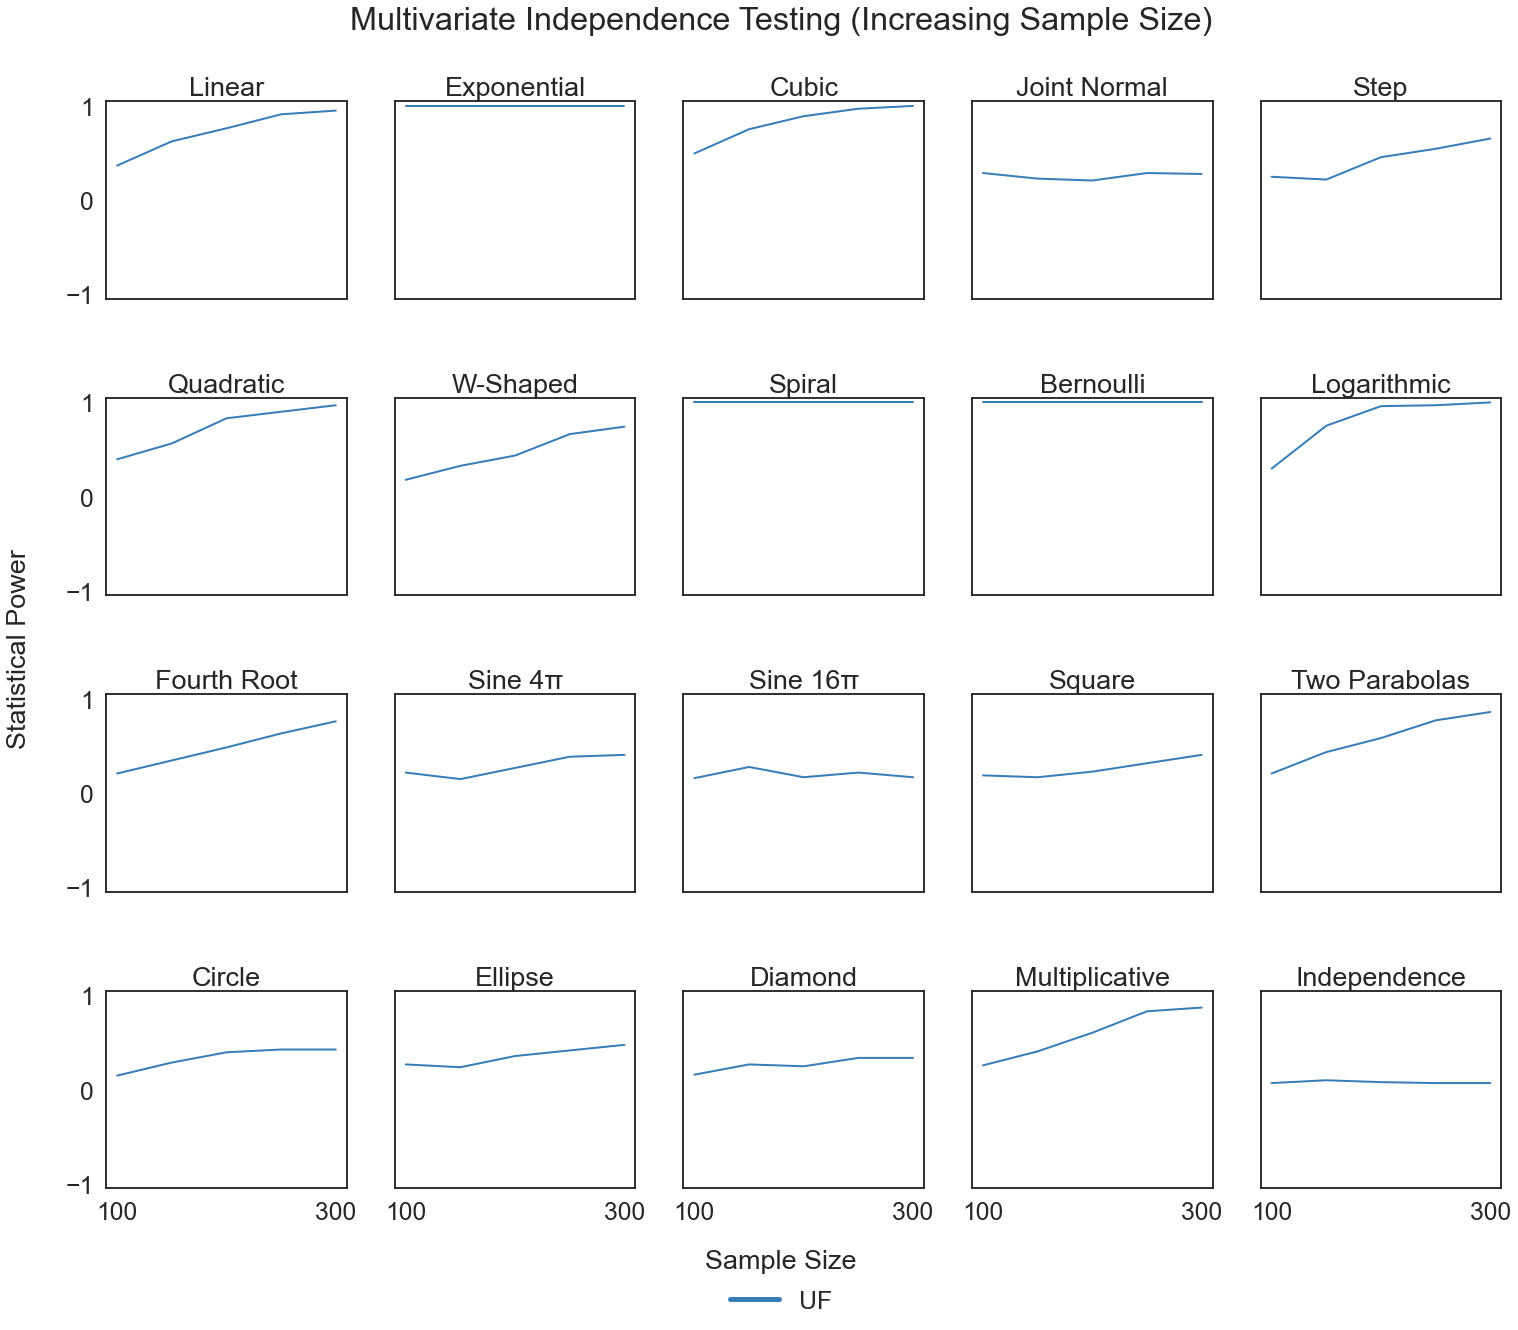

In [31]:
plot_power()